# Autoencoder example

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# A basic encoder/decoder with a single internal layer
class EncoderDecoder(nn.Module):
    def __init__(self, in_size, out_size, mid_size):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_size, mid_size), nn.ReLU(), nn.Linear(mid_size, out_size))
        self.dec = nn.Sequential(nn.Linear(out_size, mid_size), nn.ReLU(), nn.Linear(mid_size, in_size))

    def forward(self, x):
        return self.dec(self.enc(x))
    
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, x):
        return self.dec(x)


Suppose the data always looks like a periodic blips of $1$'s and $0$'s otherwise with period $2^i$, plus some small noise.

In [3]:
k = 8

# The data will just be periodic blips where the period is a power of 2 plus some noise
base_data = torch.zeros((k+1, 2 ** k))
for i in range(0, k+1):
    base_data[i, 0::2**i] = 1

# Generate the data
def generate_data(n: int):
    return base_data[torch.randint(0, k+1, size=(n,))] + torch.randn(size=(n, 2**k))*0.1


Train 4000 iterations with batch size 1024.

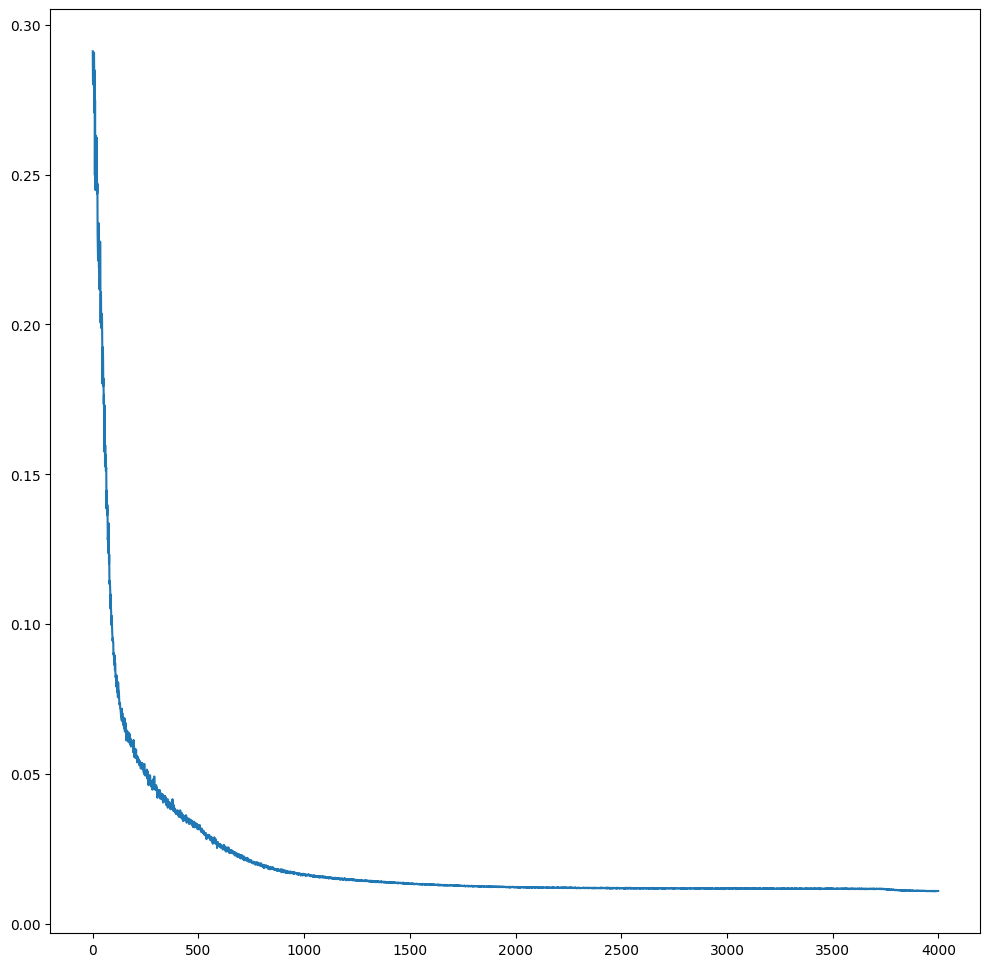

In [4]:

m = EncoderDecoder(2**k, 1, 16)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
losses = []

for i in range(4000):
    X = generate_data(1024)
    y = X.detach().clone()
    u = m.forward(X)
    loss = loss_fn(u, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())



plt.figure(figsize=(12,12))
plt.plot(range(len(losses)), losses)


With noiseless data, loss should be low.

In [5]:

e = m.encode(base_data)
d = m.decode(e)

print(f"Loss on base data: {loss_fn(d, base_data)}")

Loss on base data: 0.0008772977162152529


Encodings of the base data

In [6]:
print(f"base data encodings: \n{e}")

base data encodings: 
tensor([[11.8009],
        [ 6.0889],
        [ 1.9627],
        [ 0.1118],
        [-0.5544],
        [-1.5663],
        [-2.2316],
        [-2.6156],
        [-2.7211]], grad_fn=<AddmmBackward0>)


One can try training it on random data.  We expect no convergence, i.e. it shouldn't be possible to encode 256-dimensional data in 1-dimensional data.

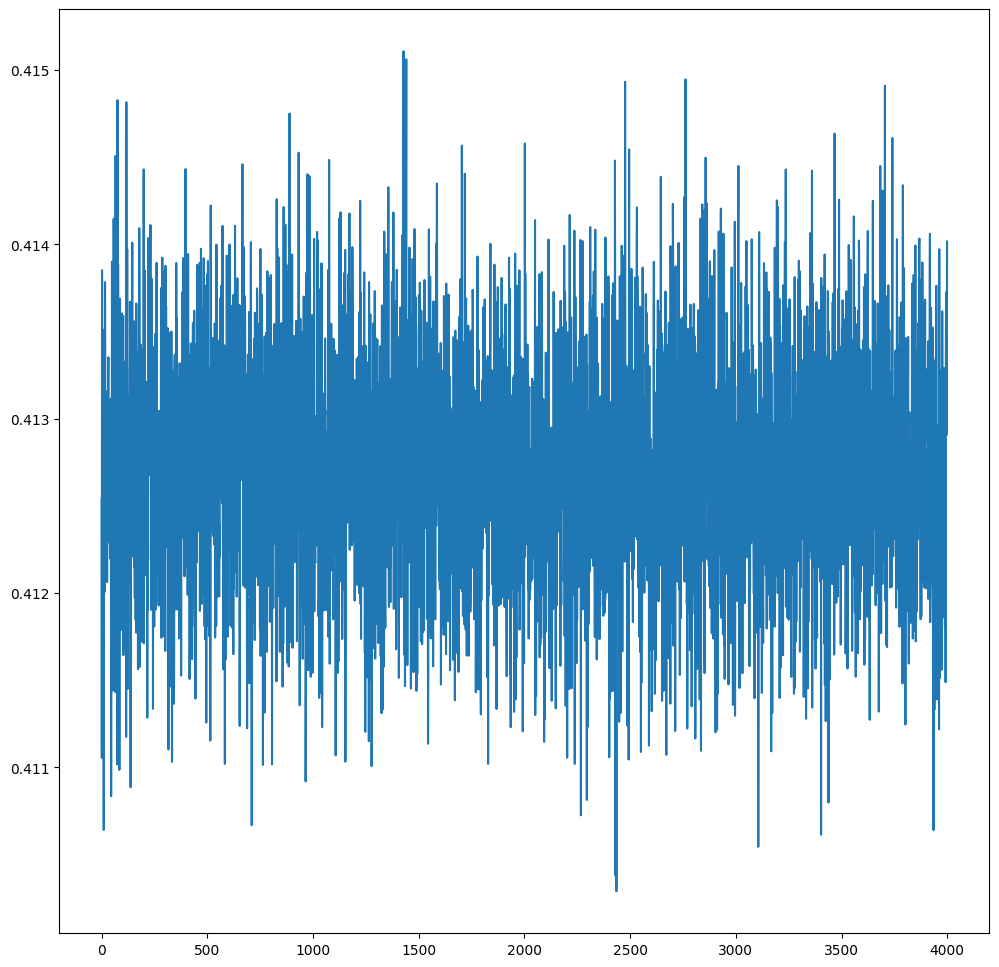

In [7]:

m2 = EncoderDecoder(2**k, 1, 16)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
losses = []

for i in range(4000):
    X = torch.rand((1024, 2**k))
    y = X.detach().clone()
    u = m2.forward(X)
    loss = loss_fn(u, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())



plt.figure(figsize=(12,12))
plt.plot(range(len(losses)), losses)


# Some PCA

Try running PCA on the periodic blips data and see what it does.  Expectation: it will still see many axes with high correlations.  The reason is that the relationship between the data entries is not linear, and PCA detects colinearity.

In [8]:
import sklearn
import scipy

X = base_data.numpy()
y = np.arange(9)
# Centered X
X0 = X - X.mean(axis=0)
y0 = y - y.mean(axis=0)

svd = scipy.sparse.linalg.svds(X0)
print(f"singular values: {svd[1]}")

singular values: [ 1.6096593  2.3904436  3.4947383  5.068036   7.6252546 15.387925 ]


In [9]:
import sklearn.decomposition

print(X.shape)
pca = sklearn.decomposition.PCA(3)
pca.fit(X)
print(pca.singular_values_)
print(pca.components_.shape)


(9, 256)
[15.387925   7.6252575  5.068036 ]
(3, 256)


In [10]:
lr = sklearn.linear_model.LinearRegression(fit_intercept=False)

X_red = pca.transform(X0)

lr.fit(X_red, y0)

print(lr.coef_)

print(lr.predict(X_red) + y.mean(axis=0))
print(y)

[-0.27005538 -0.10704301 -0.00508458]
[2.26415706 3.15403521 4.50238895 5.4413625  5.92368233 6.13514113
 6.21760678 6.24552655 6.25254297]
[0 1 2 3 4 5 6 7 8]
